In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

#%matplotlib widget

# Finding Atoms in Electron Microscopy Images with Convolutional Neural Networks

*Johannes Margraf*

This notebook illustrates how neural networks (NNs) can be used to process electron microscopy data. Specifically, we will build a model that finds atoms in simulated TEM images. Note that there are dedicated packages for this out there (*e.g.* [AtomAI](https://github.com/pycroscopy/atomai)). We'll also be using a very crude way of simulating the TEM images. Again, better solutions exist (*e.g.* [abTEM](https://abtem.readthedocs.io/en/latest/index.html)). However, for pedagogical reasons I like to implement everything from scratch as much as possible.

Let's begin by simulating our reference data. These are noisy images of randomly rotated graphene sheets:

In [2]:
def rotate_vectors(v1,v2,theta):
    '''
    Helper function for rotating two vectors
    '''
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    v1 = R@v1
    v2 = R@v2
    return v1,v2

def lattice(v1,v2,p0,size=1.0):
    '''
    Helper function for generating hexagonal lattices
    '''
    vmin = min(np.linalg.norm(v1),np.linalg.norm(v2))
    imin = int(size/vmin)
    positions = []
    for i1 in range(-imin,imin):
        for i2 in range(-imin,imin):
            v = i1*v1+i2*v2+p0
            if np.max(v)>(size+0.2):
                continue
            elif np.min(v)<-0.2:
                continue
            else:
                positions.append(v)
    return positions
    

def generate_image(dim=32,noise=0.02,defect_dens=0.95,dx=1.0/128.):
    '''
    Generates simulated TEM images of graphene sheets with point defects
    '''
    image = np.zeros((dim,dim))
    truth = np.zeros((dim,dim))
    size = dim*dx
    r = 0.07
    sigma = r/2
    a = (0.005*np.random.randn(1)+0.1)[0]
    p1 = np.array([size/2,size/2]) #np.random.rand(2)*0.6 + 0.2
    p2 = np.array([size/2,size/2+a])  #p1 + np.array([a,0.])
    v1 = (a/2.)*np.array([np.sqrt(3),3])
    v2 = (a/2.)*np.array([-np.sqrt(3),3])
    theta = np.random.rand(1)[0]*60.
    v1rot, v2rot = rotate_vectors(v1,v2,theta)
    p1rot, p2rot = rotate_vectors(p1,p2,theta)
    p1rot_trans = p1rot+(p1-p1rot)
    p2rot_trans = p2rot+(p1-p1rot)
    pos1 = lattice(v1rot,v2rot,p1rot_trans,size=size)
    pos2 = lattice(v1rot,v2rot,p2rot_trans,size=size)
    pos = pos1+pos2
    
    for position in pos:
        if np.random.rand()>defect_dens:
            continue

        mask = np.zeros_like(image)
        mask_truth = np.zeros_like(image)
        overlap = False
        icenter = [int((position[0]/dx)),int((position[1]/dx))]
        for ix in range(-int(r/dx),int(r/dx)):
            for iy in range(-int(r/dx),int(r/dx)):
                r_cur = np.sqrt(((ix)*dx)**2+((iy)*dx)**2)
                if  ((r_cur<r) and 
                    (icenter[0]+ix)<dim and
                    (icenter[1]+iy)<dim and
                    (icenter[0]+ix)>-1  and
                    (icenter[1]+iy)>-1 ): 
                    mask[icenter[0]+ix,icenter[1]+iy] += np.exp(-r_cur**2/sigma**2)
                if  ((r_cur<(r/5.)) and 
                    (icenter[0]+ix)<dim and
                    (icenter[1]+iy)<dim and
                    (icenter[0]+ix)>-1  and
                    (icenter[1]+iy)>-1 ): 
                    mask_truth[icenter[0]+ix,icenter[1]+iy] = 1
        image += mask
        truth += mask_truth
    image += np.random.randn(dim,dim)*noise + 2*noise
    return image, truth

'''
def patches_generator(image,kernel_size=3):
    image_h, image_w = image.shape
    for h in range(image_h-kernel_size+1):
        for w in range(image_w-kernel_size+1):
            patch = image[h:(h+kernel_size), w:(w+kernel_size)]
            yield patch, h, w
    
def convolutions(image):
    image_h, image_w = image.shape
    #kernel = np.array([[-1,-1,-1], # Edge_detect
    #                   [-1,8,-1],
    #                   [-1,-1,-1]])
    #kernel = np.array([[0,-1,0],   # Sharpen
    #                   [-1,5,-1],
    #                   [0,-1,0]])
    kernel_size = int(image_w/10)
    x = y = np.arange(-int(kernel_size/2),int(kernel_size/2))
    xv, yv = np.meshgrid(x, y, indexing='ij')
    kernel = np.exp(-(xv**2+yv**2)/(kernel_size/4)**2)
    kernel_size = kernel.shape[0]
    convolution_output = np.zeros((image_h-kernel_size+1, image_w-kernel_size+1))
    for patch,h,w in patches_generator(image,kernel_size=kernel_size):
        convolution_output[h,w] = np.sum(kernel*patch)
    return convolution_output
'''

from scipy import spatial, ndimage, optimize

def find_com(image_data):
    """
    Find atoms via center of mass methods
    Args:
        image_data (2D numpy array):
            2D image (usually an output of neural network)
    """
    labels, nlabels = ndimage.label(image_data)
    #print(labels)
    coordinates = np.array(
        ndimage.center_of_mass(
            image_data, labels, np.arange(nlabels) + 1))
    coordinates = coordinates.reshape(coordinates.shape[0], 2)
    return coordinates  

The function `generate_image` gets you a simulated TEM image and a map of the true locations of the atoms (allowing for the finite resolution of the images). Below you see some examples of images and the corresponding ground-truth maps. As a training set, we'll generate 100 such pairs. For the subsequent training, the images and target maps are stored in a single numpy array each.

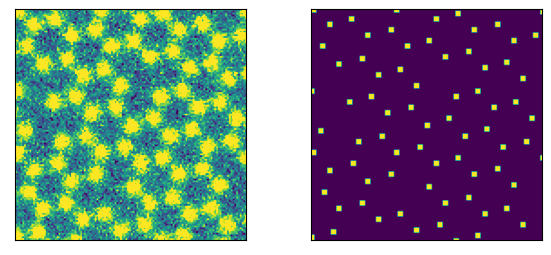

In [4]:
noise = 0.2
#for noise in [0.05,0.1,0.2,0.4,0.8]:
training_set_images = []
training_set_targets = []
for i in range(100):
    image, truth = generate_image(dim=128,noise=noise,defect_dens=0.95)
    training_set_images.append(image)
    training_set_targets.append(truth)
    if i%50==0:
        fig, ax = plt.subplots(1,2,figsize=(7, 3))
        ax[0].set_aspect('equal')
        ax[1].set_aspect('equal')
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[0].imshow(image,vmin=0.0,vmax=1.0)
        #plt.show()
        ax[1].imshow(truth)
        plt.show()
        #plt.close()
        
training_set_images = np.array(training_set_images)
training_set_targets = np.array(training_set_targets)
#plt.close()

As is good practice, we'll also generate a separate validation set to test our model on:

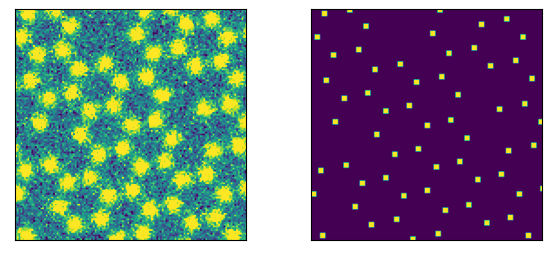

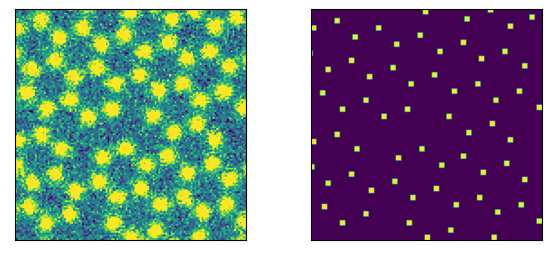

(100, 128, 128)

In [6]:
valid_set_images = []
valid_set_targets = []
for i in range(100):
    image, truth = generate_image(dim=128,noise=noise,defect_dens=0.95)
    valid_set_images.append(image)
    valid_set_targets.append(truth)
    if i%50==0:
        fig, ax = plt.subplots(1,2,figsize=(7, 3))
        ax[0].set_aspect('equal')
        ax[1].set_aspect('equal')
        ax[0].set_xticks([])
        ax[1].set_xticks([])
        ax[0].set_yticks([])
        ax[1].set_yticks([])
        ax[0].imshow(image,vmin=0.0,vmax=1.0)
        #plt.show()
        ax[1].imshow(truth)
        plt.show()
        #plt.close()
valid_set_images = np.array(valid_set_images)
valid_set_targets = np.array(valid_set_targets)
valid_set_images.shape
    #convolution = convolutions(image)
    #plt.imshow(convolution)
    #plt.show()

Now let's build the ML model. Before we get to this model we need to import some things from PyTorch and set up our generic training functions:

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


In [8]:
# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.002
BATCH_SIZE = 32
N_EPOCHS = 1200
DICE_SOFTNESS = 0.1

In [9]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Generic function for a single training epoch
    '''

    model.train()
    cummulative_loss = 0
    
    for X, Y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        Y_true = Y_true.to(device)
    
        # Forward pass
        Y_model = model(X) 
        loss = criterion(Y_model, Y_true,smooth=DICE_SOFTNESS) 
        cummulative_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = cummulative_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [10]:
def validate(valid_loader, model, criterion, device):
    '''
    Generic function for computing the validation loss
    '''
   
    model.eval()
    cummulative_loss = 0
    
    for X, Y_true in valid_loader:
    
        X = X.to(device)
        Y_true = Y_true.to(device)

        # Forward pass and record loss
        Y_model = model(X) 
        loss = criterion(Y_model, Y_true) 
        cummulative_loss += loss.item() * X.size(0)

    epoch_loss = cummulative_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [11]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the training loop
    '''
    
    # Initialize losses
    best_loss = 1e12
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == 0:               
            print(f'Epoch: {epoch} Train loss: {train_loss:.4f} Valid loss: {valid_loss:.4f}')

    plot_losses(train_losses, valid_losses)  
    return model, optimizer, (train_losses, valid_losses)

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
  
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (7, 3))

    ax.plot(train_losses, label='Training loss') 
    ax.plot(valid_losses, label='Validation loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss') 
    ax.legend()
    plt.tight_layout()
    plt.show()   
    #plt.close()


Next we take the numpy arrays containing our training and validation data and convert them to Torch `Tensors` and define the `DataLoaders`. Here the unsequeeze function is used to make explicit that our image only has a single channel (like a greyscale image).

In [12]:
training_set_images_tensor = torch.tensor(training_set_images[0:100,:,:]).float().unsqueeze(1)
training_set_targets_tensor = torch.tensor(training_set_targets[0:100,:,:]).float().unsqueeze(1)
train_set = torch.utils.data.TensorDataset(training_set_images_tensor, training_set_targets_tensor)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
#print(train_loader)
valid_set_images_tensor = torch.tensor(valid_set_images).float().unsqueeze(1)
valid_set_targets_tensor = torch.tensor(valid_set_targets).float().unsqueeze(1)
valid_set = torch.utils.data.TensorDataset(valid_set_images_tensor, valid_set_targets_tensor)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=20, shuffle=False)
#print(valid_loader)

Now we get to the really serious business of defining the Neural Network. Convolutional NNs (ConvNets) are very popular for image processing because they are able to efficiently process image data, taking advantage of translational invariance. Common ConvNets (*e.g.* AlexNet or LeNet) are quite complicated including different combinations of convolutional, pooling and dense layers. This is because they are usually used for classification, which means that they take an image as an input and provide a class label (or probability) as output. Here we want something different: We want to take the image as input and return a binary map of the same size. This means that we have to build a classifier (atom or no atom?) for each pixel in the input image. This task is commonly referred to as *semantic segmentation*, and it can be achieved with so-called fully convolutional neural networks. In the simplest case this can be achieved by exclusively using convolutional layers. We'll define such a network below:

In [13]:
class DiceLoss(nn.Module):
    '''
    The Dice Loss for semantic segmentation, function taken from https://www.kaggle.com/code/mahmoudlimam/u-net-pytorch
    '''
    def __init__(self):
        super().__init__()

    def forward(self, outputs, targets, smooth=0):
        
        outputs = outputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (outputs * targets).sum()                            
        dice = (2*intersection + smooth)/(outputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


class AtomNet(nn.Module):
    '''
    A fully convolutional network for semantic segmentation of TEM images
    '''
    def __init__(self):
        super(AtomNet, self).__init__()
        
        self.fcnn = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, stride=1, padding='same'),
            nn.Sigmoid()
        )

        self.fcnn.apply(self.init_weights)
    
    def init_weights(self,m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            #torch.nn.init.constant_(m.weight,1.)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        x = self.fcnn(x)
        return x

Next, create a model and define the optimizer and criterion (*i.e.* the loss function). The final output of our model is passed through a Sigmoid activation function so that it automatically lies between zero and one. We could now use a standard classification loss like the Binary Cross Entropy to train the network. However, this can lead to problems in our case since most pixels do not contain atoms. A model that always outputs zero would therefore have a quite low loss already and the optimization of the NN parameters is prone to fall into such a local minimum. We instead use the (soft) Dice loss, which is commonly employed in semantic segmentation problems.

In [14]:
torch.manual_seed(7)

model = AtomNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = DiceLoss()

In [15]:
# Pass an example through the network as a sanity check
model.forward(training_set_images_tensor[0,:,:,:])

tensor([[[0.5003, 0.4993, 0.5005,  ..., 0.5005, 0.5012, 0.5017],
         [0.5005, 0.5003, 0.5019,  ..., 0.5019, 0.5022, 0.5032],
         [0.4989, 0.4990, 0.5010,  ..., 0.5005, 0.5020, 0.5029],
         ...,
         [0.5006, 0.4987, 0.4997,  ..., 0.5006, 0.5003, 0.5024],
         [0.5018, 0.5008, 0.5043,  ..., 0.5013, 0.5009, 0.5029],
         [0.5001, 0.5065, 0.5073,  ..., 0.5032, 0.5045, 0.5043]]],
       grad_fn=<SigmoidBackward0>)

And with this, we're ready to train the model. Note that this can take a while (several minutes) if you are running on CPUs:

Epoch: 0 Train loss: 0.9235 Valid loss: 0.9242
Epoch: 100 Train loss: 0.3997 Valid loss: 0.3949
Epoch: 200 Train loss: 0.2805 Valid loss: 0.2814
Epoch: 300 Train loss: 0.1401 Valid loss: 0.1413
Epoch: 400 Train loss: 0.1229 Valid loss: 0.1241
Epoch: 500 Train loss: 0.1164 Valid loss: 0.1172
Epoch: 600 Train loss: 0.1125 Valid loss: 0.1129
Epoch: 700 Train loss: 0.1107 Valid loss: 0.1111
Epoch: 800 Train loss: 0.1087 Valid loss: 0.1091
Epoch: 900 Train loss: 0.1073 Valid loss: 0.1077
Epoch: 1000 Train loss: 0.1061 Valid loss: 0.1072
Epoch: 1100 Train loss: 0.1055 Valid loss: 0.1060


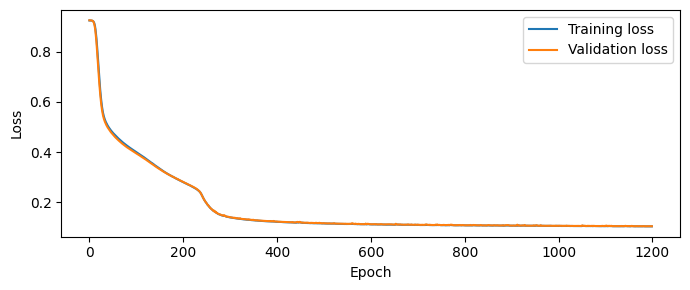

In [16]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE,print_every=100)

We can see that the training and validation errors are quite close to each other throughout the optimization. This indicates that the model is not overfitting on the training data. It also looks like the model basically converged within the 1200 epochs. You can go back and change learning rate and batch size to see if you can train more efficiently.

Once the model is trained we can look at how the segmentation worked for some of the validation samples.

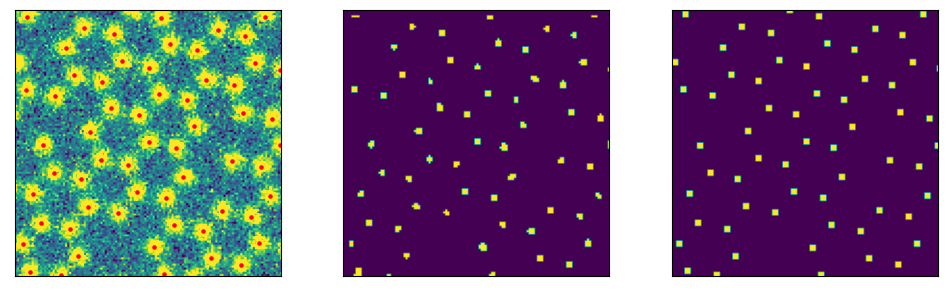

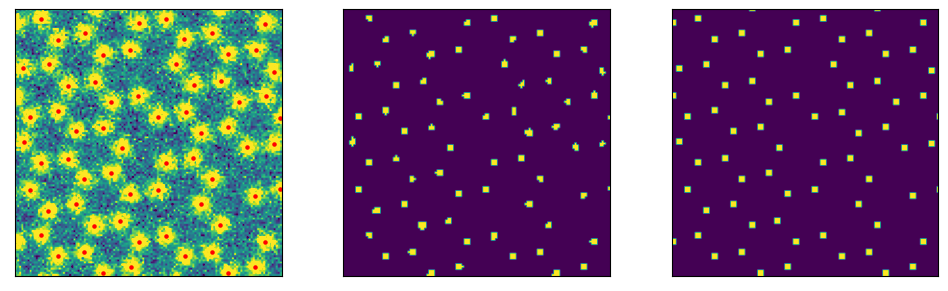

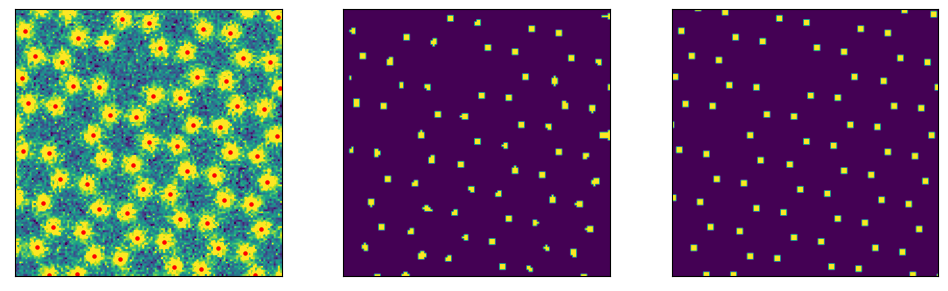

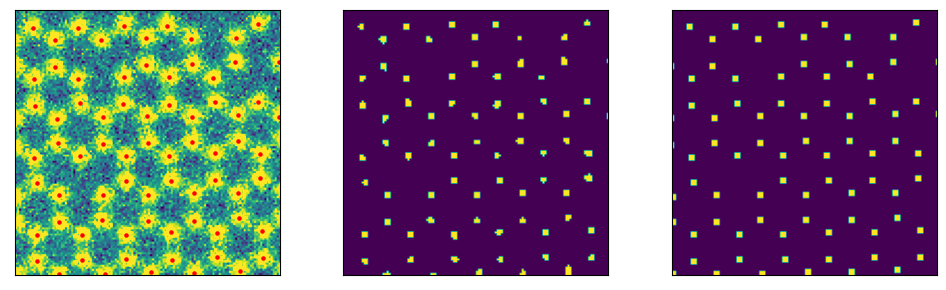

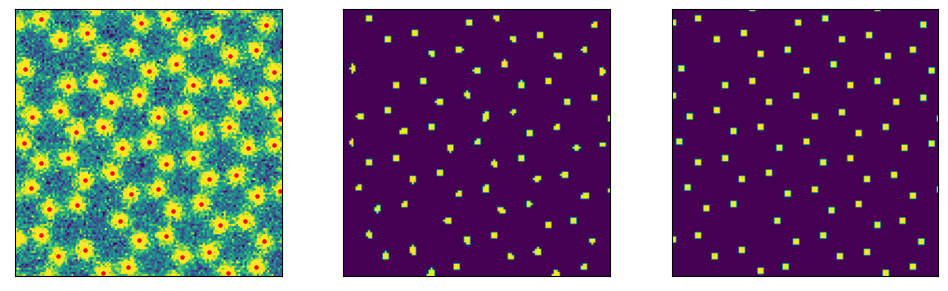

In [20]:
for i in range(0,100,20):
    out = model.forward(valid_set_images_tensor[i,:,:,:])
    out_raw = out.detach().squeeze(0).numpy()
    out = np.round(out.detach().squeeze(0).numpy())
    coords = find_com(out)
    #print(coords)
    fig, ax = plt.subplots(1,3,figsize=(10, 3))
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    ax[2].set_aspect('equal')
    ax[0].set_xticks([])
    ax[1].set_xticks([])
    ax[2].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_yticks([])
    ax[2].set_yticks([])
    im = ax[1].imshow(out,origin='lower')
    ax[0].scatter(coords[:,1],coords[:,0],s=5,c='r')
    #fig.colorbar(im, orientation='vertical')    #plt.show()
    ax[2].imshow(valid_set_targets_tensor[i,:,:,:].detach().squeeze(0).numpy(),origin='lower')
    #ax[2].imshow(out_raw,origin='lower')
    plt.tight_layout()
    ax[0].imshow(valid_set_images_tensor[i,:,:,:].detach().squeeze(0).numpy(),origin='lower',vmin=0.0,vmax=1.0)
    plt.show()


Looks like our AtomNet is doing a good job. On the left figures you see the simulated TEM image. The red points represent the centers of mass of the yellow patches in the central figure. This is the output of the neural network. It's not a perfect match of the ground truth (right), but this is to be expected since the image is somewhat noisy. More importantly, there's an atom at every density peak in the image and there are no atoms predicted to be anywhere else. This is non-trivial since detecting maxima in noisy images can easily lead to artefacts.

To obtain some deeper insight into how these predictions are made, we can look at how the image is processed as it passes through the network. These intermediate states are also called feature maps.

In [49]:
layers = list(list(model.children())[0].children())
convtype = [0,2,4]
print(layers)

[Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=same), ReLU(), Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=same), ReLU(), Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=same), Sigmoid()]


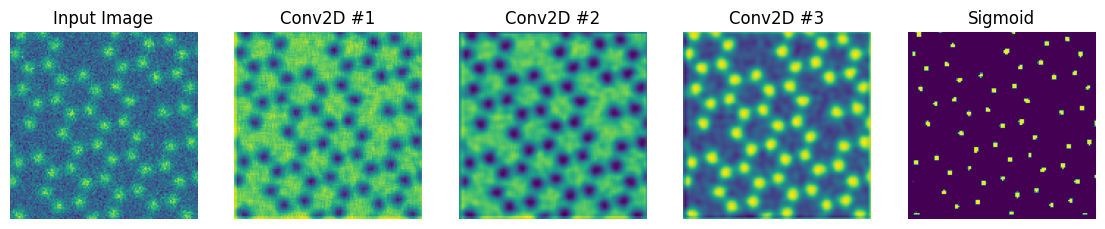

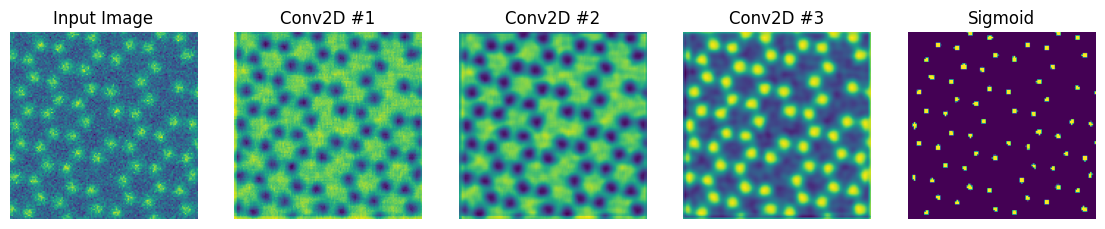

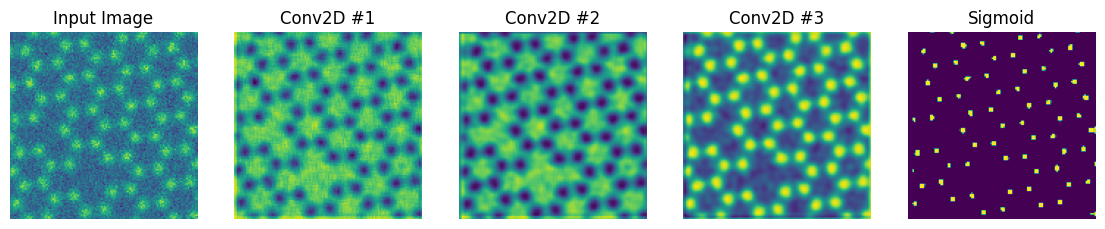

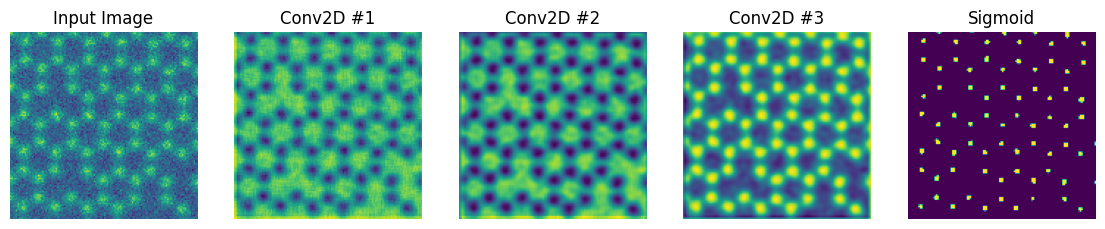

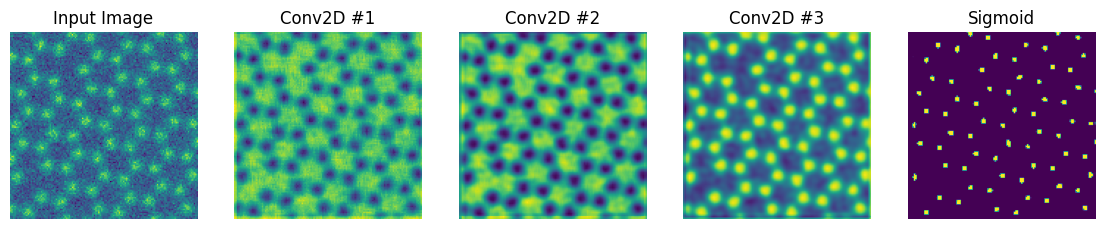

In [50]:
for i_image in range(0,100,20):
    image = valid_set_images_tensor[i_image,:,:,:]
    fig, ax = plt.subplots(1,5,figsize=(14, 3))
    ax[0].axis('off')
    ax[0].imshow(image.detach().squeeze(0).numpy())
    ax[0].set_title(f"Input Image")
    axcount = 0
    for i,layer in enumerate(layers):
        image = layer(image)
        if i in convtype:
            axcount+=1
            ax[axcount].axis('off')
            ax[axcount].imshow(image.detach().squeeze(0).numpy())
            ax[axcount].set_title(f"Conv2D #{axcount}")
        if i == 5:
            axcount+=1
            ax[axcount].axis('off')
            ax[axcount].imshow(image.detach().squeeze(0).numpy())
            ax[axcount].set_title(f"Sigmoid")
    plt.show()
    

We can see that the image is gradually denoised, while the atom positions are sharpened as the image is passed through the network.

Finally, we can also look at the weight matrices of the convolutional layers. These are usually called filters and they represent the transformations that the model has learned.

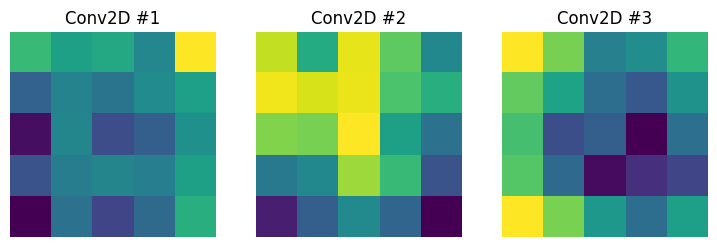

In [48]:
fig, ax = plt.subplots(1,3,figsize=(9, 3))
axcount = 0
for i,layer in enumerate(layers):
    if i in convtype:
        weight = layer.weight.detach().squeeze(0).squeeze(0).numpy()
        ax[axcount].imshow(weight)
        ax[axcount].axis('off')
        ax[axcount].set_title(f"Conv2D #{axcount+1}")
        axcount +=1